In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
device = 'cuda'
dtype = torch.float32
as_tensor = lambda x: torch.as_tensor(x, device=device, dtype=dtype)

Load perfect data

In [4]:
from utils_loading import load_data
from utils_3d import normalize_patches, disp3D, disp2D

In [5]:
dirname = "perfect"
rootdir = f"/data/plumail/generated_data/inputs/{dirname}"
patches, coords, angles, views, poses, psf = map(as_tensor, load_data(rootdir))

In [6]:
patches_2D = patches.sum(dim=1)
patches_2D = normalize_patches(patches_2D)

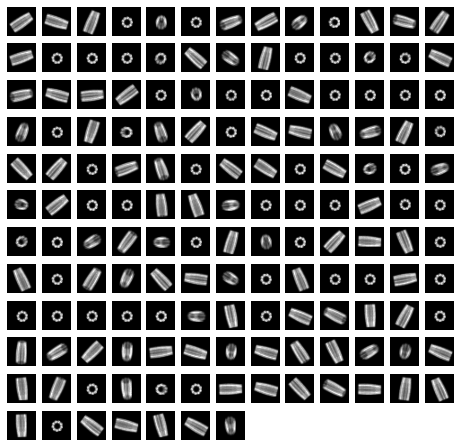

In [7]:
fig = plt.figure(figsize=(8,8))
disp2D(fig, *patches_2D.cpu().numpy(), cmap='gray')

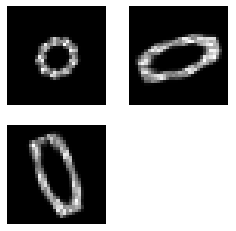

In [8]:
fig = plt.figure(figsize=(4,4))
disp3D(fig, patches[8].cpu().numpy())

/home/plumail/stage/SPFluo_stage_reconstruction_symmetryC/utils_3d.py:51: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  transform_[:,:3] = torch.as_tensor(Rotation.from_euler('zxz', euler_angles, degrees=True).inv().as_euler('zxz', degrees=True).copy(), device=transform.device, dtype=transform.dtype)


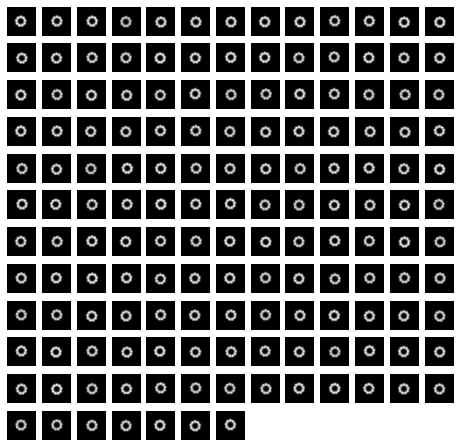

In [9]:
from utils_3d import inverse_affine_transform
import torch

patches_transformed = inverse_affine_transform(patches[:,None], poses)[:,0]
patches_transformed_2D = patches_transformed.sum(dim=1)
patches_transformed_2D = normalize_patches(patches_transformed_2D)

fig = plt.figure(figsize=(8,8))
disp2D(fig, *patches_transformed_2D.cpu().numpy(), cmap='gray')

Reconstruction L2

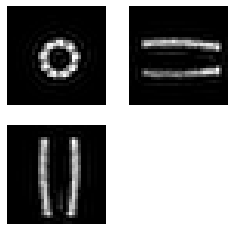

In [10]:
from utils_3d import reconstruction_L2

psf = psf / psf.sum()

lambda_ = 5e-5
recon, den = reconstruction_L2(patches, psf, poses, lambda_)
fig = plt.figure(figsize=(4,4))
disp3D(fig, recon.cpu().numpy())

In [42]:
%timeit reconstruction_L2(patches, psf, poses, lambda_)

13.7 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
device = 'cpu'
%timeit reconstruction_L2(torch.as_tensor(patches, device=device), torch.as_tensor(psf, device=device), torch.as_tensor(poses, device=device), lambda_)

/home/plumail/stage/SPFluo_stage_reconstruction_symmetryC/utils_3d.py:50: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  transform_[:,:3] = torch.as_tensor(Rotation.from_euler('zxz', euler_angles, degrees=True).inv().as_euler('zxz', degrees=True).copy(), device=transform.device, dtype=transform.dtype)


1.06 s ± 242 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Based on the L2 reconstruction, find back the angles of the patches with the find_angles_grid function.

In [14]:
from utils_3d import find_angles_grid

best_poses, errors = find_angles_grid(recon, patches, psf, precision=10)

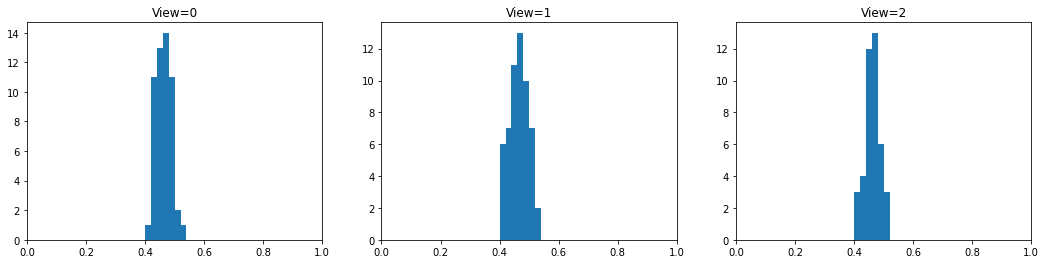

In [15]:
plt.figure(figsize=(6*3,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(f"View={i}")
    plt.hist(errors[views==i].cpu().numpy(), bins=np.arange(0,1,0.02))
    plt.xlim(0,1)

Text(0.5, 1.0, 'Cross-correlation error vs angle error')

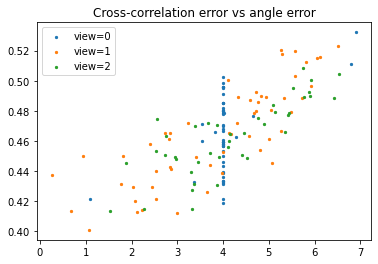

In [16]:
from utils_3d import distance_poses

angle, d = distance_poses(torch.as_tensor(poses, device=best_poses.device, dtype=best_poses.dtype), best_poses)
plt.figure(figsize=(6,4))
for i in range(3):
    plt.scatter(np.abs(angle[views==i].cpu().numpy()), errors[views==i].cpu().numpy(), s=5, label=f"view={i}")
plt.legend()
plt.title("Cross-correlation error vs angle error")

In [18]:
from utils_3d import affine_transform

N = 100
random_angles = np.random.random(size=(100,3)) * 360
random_poses = np.concatenate([random_angles, np.zeros((N,3))], axis=1)
test_patches = affine_transform(recon[None].repeat(N,1,1,1)[:,None], as_tensor(random_poses))[:,0]


In [26]:
out = []
precision = np.geomspace(2, 30, num=10)[::-1]
for p in precision:
    print("precision =", p)
    best_poses, errors = find_angles_grid(recon, test_patches, psf, precision=p)
    angle, d = distance_poses(as_tensor(random_poses), best_poses)
    #angle[angle>90] = 180 - angle[angle>90]
    out.append(np.median(angle.cpu().numpy()))

precision = 30.0
precision = 22.204676389551587
precision = 16.434921785490328
precision = 12.164403991146798
precision = 9.003555136506147
precision = 6.664034272053467
precision = 4.93242414866094
precision = 3.6507627345675218
precision = 2.702133503203542
precision = 2.0


(0.0, 13.0)

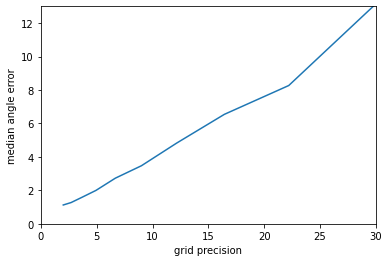

In [28]:
angle_error = np.stack(out)
plt.plot(precision, out)
plt.xlabel('grid precision')
plt.ylabel('median angle error')
plt.xlim(0, 30)
plt.ylim(0, 13)

Reconstruction L2 avec top et side seulement. Information sur l'angle relatif des sides.

tensor([[195.4386,  90.0000,  56.1341],
        [277.0149, 270.0000, 287.3436]], device='cuda:0')


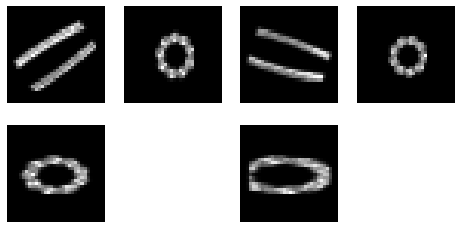

In [30]:
patches_side = patches[views==1]
fig = plt.figure(figsize=(8,4))
print(poses[views==1][[0,1],:3])
disp3D(fig, patches_side[0].cpu().numpy(), patches_side[1].cpu().numpy())

/home/plumail/stage/SPFluo_stage_reconstruction_symmetryC/utils_3d.py:51: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  transform_[:,:3] = torch.as_tensor(Rotation.from_euler('zxz', euler_angles, degrees=True).inv().as_euler('zxz', degrees=True).copy(), device=transform.device, dtype=transform.dtype)


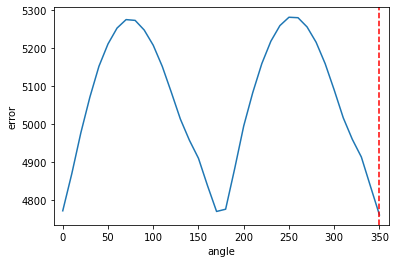

In [33]:
errors = []
recons= []
step = 10
lambda_ = 5e-2
sigma = 20
for delta in torch.arange(0, 360, step):

    poses_noised = poses.clone()
    poses_noised[:, 3:] = 0
    #poses_noised[:, :3] += torch.randn_like(poses_noised[:,:3]) * sigma # désaligne les particules side légèrement
    poses_noised[:, 0] = 0
    poses_noised[views==0, 1:3] = 0
    poses_noised[views==1, 1] = 90
    poses_noised[views==1, 2] += delta

    mask_top_side = torch.logical_or(views==0, views==1)
    recon_noised, _ = reconstruction_L2(patches[mask_top_side], psf, poses_noised[mask_top_side], lambda_)
    recons.append(recon_noised)
    
    N = patches[mask_top_side].shape[0]
    recon_noised_transformed = affine_transform(recon_noised[None].repeat(N,1,1,1).unsqueeze(1), poses_noised[mask_top_side])[:,0]

    error = (((recon_noised_transformed - patches[mask_top_side])**2).view(N,-1).sum(dim=1)**0.5).sum() / N
    errors.append(error.cpu().item())

plt.xlim(-step,360)
x = torch.arange(0, 360, step).cpu().numpy()
errors = np.array(errors)
i = errors.argmin()
plt.ylabel("error")
plt.xlabel("angle")
plt.plot(x, errors)
plt.axvline(x[i], 0, 1, color='red', ls='--')

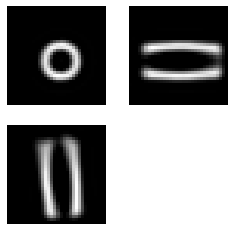

In [34]:
fig = plt.figure(figsize=(4,4))
disp3D(fig, recons[i].cpu().numpy())

Test sur différents niveaux de bruits

In [20]:
import os
import pickle
import glob
import torch

from utils_3d import first_reconstruction

os.chdir('/home/plumail/stage/minisource')

data_dirs = glob.glob("/data/plumail/generated_data/inputs/inputs*")
device = 'cuda'
dtype = torch.float32
out = []
as_tensor = lambda x: torch.as_tensor(x, dtype=dtype, device=device)
for data_dir in data_dirs:
    config_path = os.path.join(data_dir, 'config.pickle')
    with open(config_path, 'rb') as f:
        config = pickle.load(f)
    patches, coords, angles, views, poses, psf = load_data(data_dir)
    delta, recon, error = first_reconstruction(as_tensor(patches), as_tensor(views), as_tensor(poses), as_tensor(psf), step=1)
    out.append((config.sensor.anisotropic_blur_sigma, config.sensor.gaussian_noise_target_snr_db, delta, recon, error))

/home/plumail/stage/minisource/utils_3d.py:62: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  transform_[:,:3] = torch.as_tensor(Rotation.from_euler('zxz', euler_angles, degrees=True).inv().as_euler('zxz', degrees=True).copy(), device=transform.device, dtype=transform.dtype)


In [53]:
import pandas as pd

df = pd.DataFrame(list(map(lambda x:(x[0][0],x[1],x[2].cpu().item(),x[4].cpu().item()), out)), columns=["anisotropic_blur","gaussian_nois_snr","delta","error"])
df["delta"] = df["delta"].astype(float) % 180
df.loc[df["delta"] > 90, "delta"] = df[df["delta"] > 90]["delta"] - 180
df.head()

,anisotropic_blur,gaussian_nois_snr,delta,error
0,9.0,11.111111,-2.0,10947.177734
1,8.0,5.555556,-5.0,10654.317383
2,3.0,5.555556,-2.0,8924.691406
3,4.0,0.000000,-2.0,9242.033203
4,10.0,5.555556,-8.0,11575.143555


Text(0, 0.5, 'erreur angle')

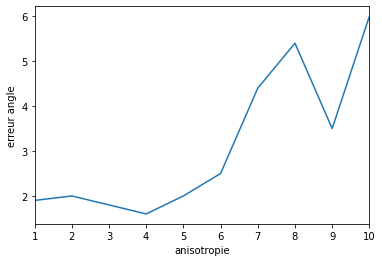

In [66]:
df["delta_abs"] = df["delta"].abs()

plt.plot(df.groupby('anisotropic_blur').mean()['delta_abs'])
plt.xlim(1, 10)
plt.xlabel("anisotropie")
plt.ylabel("erreur angle")

Text(0, 0.5, 'erreur angle')

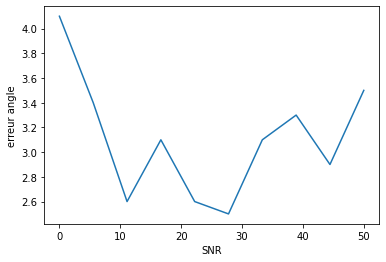

In [74]:
df["delta_abs"] = df["delta"].abs()

plt.plot(df.groupby('gaussian_nois_snr').mean()['delta_abs'])
#plt.xlim(1, 10)
plt.xlabel("SNR")
plt.ylabel("erreur angle")

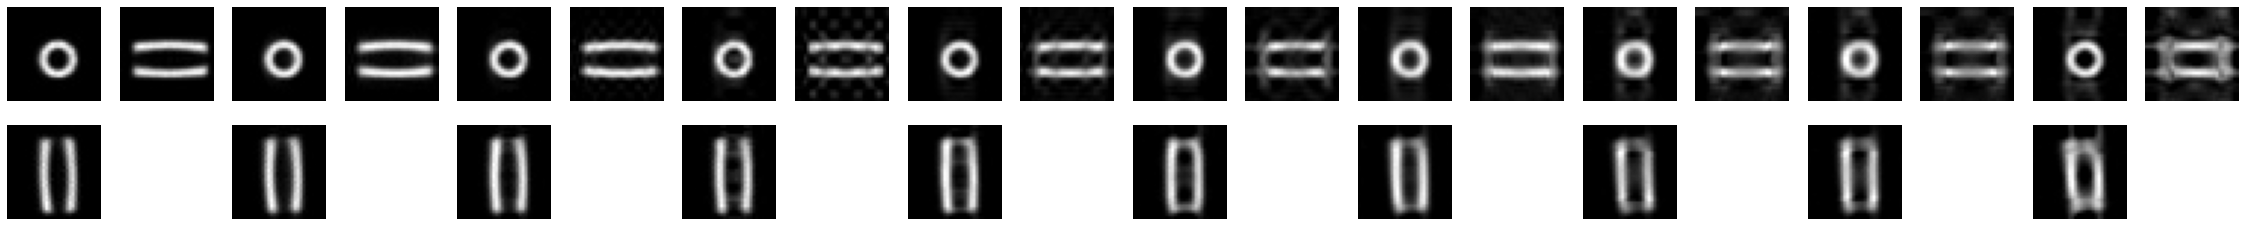

In [64]:
snr_vals = sorted(list(set(map(lambda x:x[1], out))))
recons = list(filter(lambda x:x[1]==snr_vals[0], out))
recons = sorted(recons, key=lambda x:x[0][0])
fig = plt.figure(figsize=(10*4,4))
disp3D(fig, *[x[3].cpu().numpy() for x in recons])

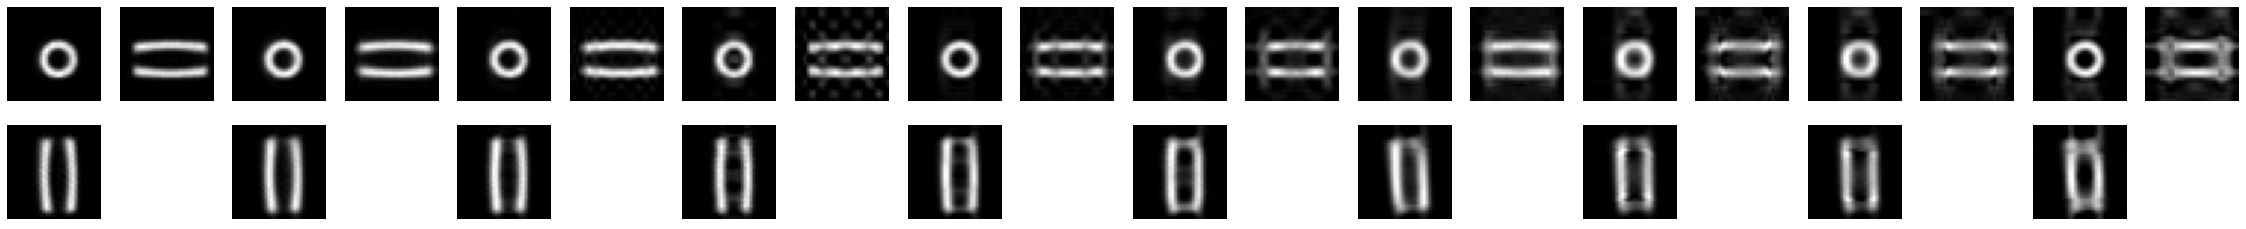

In [65]:
recons = list(filter(lambda x:x[1]==snr_vals[-1], out))
recons = sorted(recons, key=lambda x:x[0][0])
fig = plt.figure(figsize=(10*4,4))
disp3D(fig, *[x[3].cpu().numpy() for x in recons])

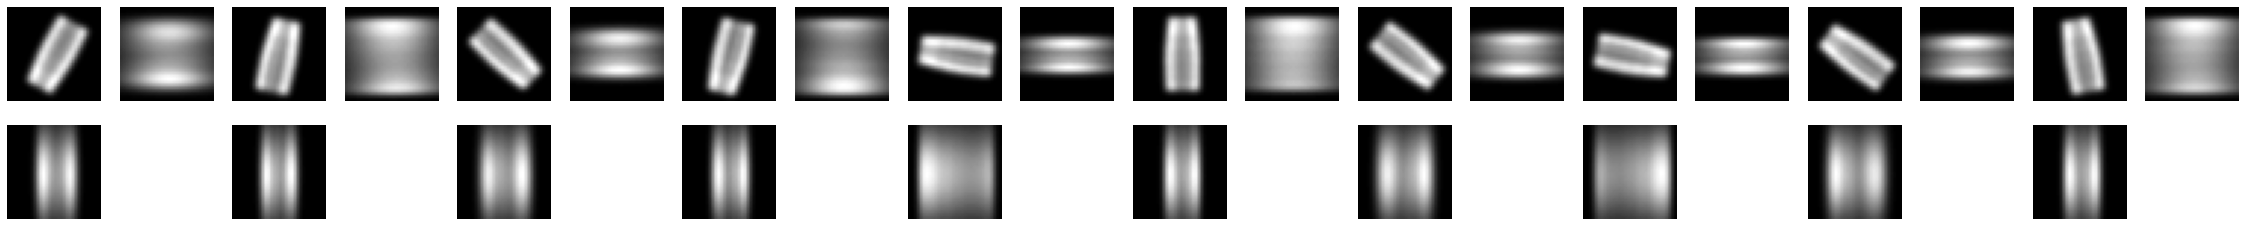

In [72]:
patches, coords, angles, views, poses, psf = load_data("/data/plumail/generated_data/inputs/inputs_blur=10.0_snr=11.11111111111111")
fig = plt.figure(figsize=(4*10,4))
disp3D(fig, *patches[views==1][:10])